In [ ]:
!pip install python-mecab-ko

In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime
import time
import re

from mecab import MeCab

In [ ]:
# 데이터 불러오기
df = pd.read_csv(file_path + 'total_webtoon_data(2).csv')

In [ ]:
import copy

# DataFrame 복사
new_df = copy.deepcopy(df)

not_nan_df = new_df[pd.notna(new_df['Category_Tag'])]
nan_df = new_df[pd.isna(new_df['Category_Tag'])]

print(len(not_nan_df), len(nan_df))

1380 179


In [ ]:
# 유 : not_nan_df 무: nan_df
train_data = not_nan_df
test_data = nan_df

# DataFrame 복사
t_data = copy.deepcopy(train_data)
z = t_data

In [ ]:
z['Title'] = z['Title'].apply(lambda x: re.sub(r'\d+$', '', str(x)))
z.drop_duplicates(subset=['Title'], inplace=True)

# 각 웹툰의 텍스트 데이터를 담을 리스트 생성
mecab = MeCab()
webtoon_text_data = []
# 웹툰 제목을 담을 리스트 생성
webtoon_titles = []

for index, row in z.iterrows():
    title = str(row['Title'])
    summary = re.sub('[a-zA-Z0-9]', '', str(row['Summary']))
    category = str(row['Category_Tag'])

    text_data = title + ' ' + ''.join(summary) + ' ' + category
    webtoon_text_data.append(text_data)
    webtoon_titles.append(title)  # 제목을 별도의 리스트에 저장

In [ ]:
print(webtoon_titles)

['도굴왕', '8서클 마법사의 환생', '악녀를 죽여 줘', '고백의 이유', '아비무쌍', '교환 남녀', '그녀가 공작저로 가야 했던 사정', '만렙 공녀는 오늘도 무료하다', '공작부인의 50가지 티 레시피', '8클래스 마법사의 회귀', '나 혼자 만렙 귀환자', '나를 버려주세요', '악녀의 애완동물', '폭군의 번역기가 되어버렸다', '아델린의 깊은 밤', '결혼 대행', '황제와 여기사', '오라버니가 너무 순해서 걱정이다', '금복이 이야기', '이번 생은 내가 주인입니다', '날것 : 공작가의 하녀로 빙의했습니다', '폭군의 애착인형', '시한부 악녀의 해피엔딩', '악녀가 사랑할 때', '공작님을 길들여 버렸습니다', '남자 주인공이 내 앞길을 가로막는다', '이미테이션', '쌍둥이 남매의 뉴라이프', '나의 보스와 정글에서', '시카 울프', '용이 비를 내리는 나라', '못난이 공녀가 되었습니다', '웨딩 임파서블', '그 오빠들을 조심해!', '버림 받은 황비', '내가 딸이에요?', '훈수 두는 천마님', '비오는 날의 시간', '폭군의 유일한 조향사가 되었습니다', '회귀한 영애는 디저트 가게를 연다', '너를 만나다', '호접몽전', '너는, 달아', '소설 속 악녀 황제가 되었다', '사실, 그들은 오직 그녀만을 기억하고 있었습니다', '지옥에서 독식', '전지적 짝사랑 시점', '대군으로 살어리랏다', '내 딸은 음악천재', '지구의 주인은 고양이다', '극한견주', '처음부터 여기 있었는데요', '광룡기', '폭군의 보호자는 악역 마녀입니다', '정령왕의 딸', '천재 아이돌의 연예계 공략법', '악녀 카루나가 작아졌어요', '마이 페어 풋맨', '은밀한 나의 동거인', '네 이웃의 취향', '99만 전생이 날 도와줘', '검마도', '이세계의 황비', '천하제일살수', '악역에게 청혼받았습니다', '이 헌터 실화냐', '검은머리 황녀님', '목표는 금수저로 무병장수하기입니다', '한 번 해본 사이', '생사결: 여래의 복수

# KoBERT

In [ ]:
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
import numpy as np

In [ ]:
# koBERT 모델과 토크나이저 불러오기
model_name = 'kykim/bert-kor-base'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_embeddings(texts):
    # 텍스트를 토크나이징하고 모델에 입력
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():  # 그라디언트 계산을 비활성화
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
batch_size = 5  # 적당한 배치 사이즈 설정

# 미니 배치 처리를 위한 임베딩 벡터 계산
webtoon_embeddings = []
for i in range(0, len(webtoon_text_data), batch_size):
    batch_texts = webtoon_text_data[i:i+batch_size]
    batch_embeddings = get_embeddings(batch_texts)
    webtoon_embeddings.append(batch_embeddings)

# 계산된 배치들을 하나의 임베딩 텐서로 병합
webtoon_embeddings = torch.cat(webtoon_embeddings, dim=0)

In [ ]:
# 사용자 입력 받기
user_input = input("추천을 원하는 웹툰을 입력하세요: ")
user_embedding = get_embeddings([user_input])

# 입력 텍스트와 각 웹툰 간의 유사도 계산
similarities = cosine_similarity(user_embedding.detach().numpy(), webtoon_embeddings.detach().numpy()).flatten()
top_indices = np.argsort(similarities)[::-1][:10]


print(f'\n"{user_input}"과(와) 유사한 웹툰 추천:\n')
for rank, index in enumerate(top_indices, start=1):
    # 웹툰 제목 리스트를 이용하여 출력
    print(f"{rank}. {webtoon_titles[index]} (유사도: {similarities[index]:.2f})")


추천을 원하는 웹툰을 입력하세요: 판타지 일상 힐링

"판타지 일상 힐링"과(와) 유사한 웹툰 추천:

1. 작은 새들 (유사도: 0.59)
2. 이상한 가족 (유사도: 0.58)
3. 알지 못했던 힘 (유사도: 0.58)
4. 에이지 오브 다이노소어 (유사도: 0.58)
5. 비극적인 사랑 (유사도: 0.58)
6. 혁명의 서막 (유사도: 0.57)
7. 하나뿐인 내 친구 (유사도: 0.57)
8. 눈 떠 보니 이세계  (유사도: 0.57)
9. 승리를 향하여!  (유사도: 0.56)
10. 새롭게 시작합시다  (유사도: 0.56)


# 모델 구현

In [ ]:
# !pip install 'git+https://git@github.com/SKTBrain/KoBERT.git@master'
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-i3fop_n3/kobert-tokenizer_3c1ac21b31284051b9fbf9fb1177f92f
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-i3fop_n3/kobert-tokenizer_3c1ac21b31284051b9fbf9fb1177f92f
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [ ]:
# 유 : not_nan_df 무: nan_df
train_data = not_nan_df
test_data = nan_df

# DataFrame 복사
t_data = copy.deepcopy(train_data)
z2 = t_data

In [ ]:
from kobert_tokenizer import KoBERTTokenizer

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
tokenizer.encode("한국어 모델을 공유합니다.")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


[2, 4958, 6855, 2046, 7088, 1050, 7843, 54, 3]

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
num_classes = len(z2['Category_Tag'].unique())
print(num_classes)

904


In [ ]:
data = z2
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

#라벨을 정수로 매핑하는 사전 생성
label_mapping = {label: idx for idx, label in enumerate(data['Category_Tag'].unique())}

# 라벨을 정수로 변환
train_data['Category_Tag'] = train_data['Category_Tag'].map(label_mapping)
test_data['Category_Tag'] = test_data['Category_Tag'].map(label_mapping)

# BERT 토크나이저로 문장을 토큰으로 변환
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

train_encodings = tokenizer(list(train_data['Title']), truncation=True, padding=True, max_length=128, return_tensors='tf')
test_encodings = tokenizer(list(test_data['Title']), truncation=True, padding=True, max_length=128, return_tensors='tf')

# 라벨을 원-핫 인코딩으로 변환
train_labels = tf.keras.utils.to_categorical(train_data['Category_Tag'], num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_data['Category_Tag'], num_classes=num_classes)

# BERT 모델 로드
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=num_classes)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 모델 학습
history = model.fit(
    {'input_ids': train_encodings['input_ids'], 'token_type_ids': train_encodings['token_type_ids'], 'attention_mask': train_encodings['attention_mask']},
    train_labels,
    epochs=10,
    batch_size=32,
    validation_data=({'input_ids': test_encodings['input_ids'], 'token_type_ids': test_encodings['token_type_ids'], 'attention_mask': test_encodings['attention_mask']}, test_labels)
)

Epoch 1/10
35/35 [==============================] - 512s 11s/step - loss: 7.4766 - accuracy: 0.0018 - val_loss: 7.6270 - val_accuracy: 0.0109
Epoch 2/10
35/35 [==============================] - 386s 11s/step - loss: 7.2205 - accuracy: 0.0118 - val_loss: 11.6057 - val_accuracy: 0.0109
Epoch 3/10
35/35 [==============================] - 375s 11s/step - loss: 7.3774 - accuracy: 0.0082 - val_loss: 8.7763 - val_accuracy: 0.0109
Epoch 4/10
35/35 [==============================] - 360s 10s/step - loss: 9.3927 - accuracy: 0.0063 - val_loss: 7.9268 - val_accuracy: 0.0036
Epoch 5/10
17/35 [=============>................] - ETA: 2:52 - loss: 8.5188 - accuracy: 0.0074

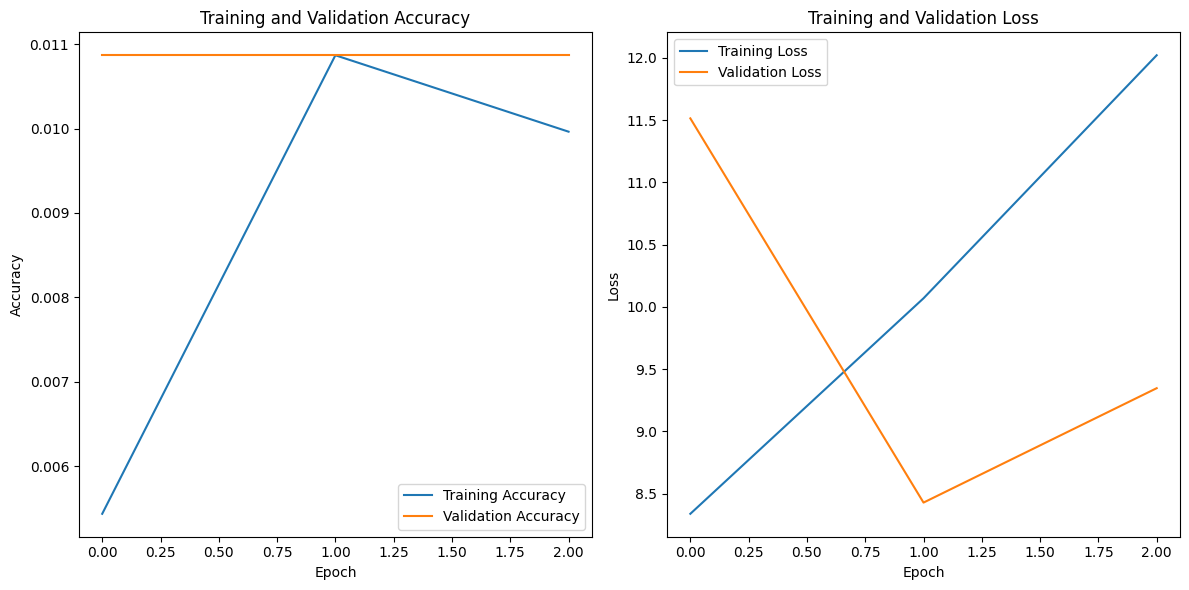

In [ ]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
